In [191]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from collections import defaultdict
from itertools import product

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import product
import numpy as np
import pandas as pd
from collections import defaultdict
# Get the parent directory of the current file (notebook)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the parent directory to sys.path
sys.path.append(parent_dir)
import warnings

warnings.filterwarnings('ignore')




In [192]:
df_ = pd.read_csv(f"{parent_dir}/Data/features_4_model.csv")

In [193]:
df_.head()

,mean_attention_score,question,label,person,mean_vector,mean_tf_idf_seg_txt,degree_centrality,betweenness_centrality,subtree_depth,tree_balance,...,gender_count_-1,number_count_-1,person_count_3,PREPOSITION,RB,REL,dale_chall_readability_score,TSNE1,TSNE2,TSNE3
0,0.599159,בר מצווה,1,אש1.docx,1687.038961,0.127176,0.021277,0.001640,11.0,0.925532,...,50.0,50.0,12.0,1.0,1.0,1.0,14.59,-41.002922,-29.769234,-5.931169
1,0.603158,מה אוהב לעשות,1,אש1.docx,12709.600000,0.707107,0.400000,0.033333,2.0,0.600000,...,3.0,3.0,0.0,1.0,0.0,0.0,19.62,-41.002922,-29.769234,-5.931169
2,0.603158,מה מעצבן,1,אש1.docx,4555.571429,0.339200,0.095238,0.015163,6.0,0.857143,...,13.0,13.0,2.0,1.0,0.0,1.0,14.89,-41.002922,-29.769234,-5.931169
3,0.445655,משאלות לעתיד,1,אש1.docx,4350.703704,0.217150,0.055556,0.011998,11.0,0.833333,...,26.0,26.0,3.0,1.0,1.0,1.0,14.38,-41.002922,-29.769234,-5.931169
4,0.603158,תמונה 1,1,אש1.docx,2577.379310,0.173194,0.054054,0.005448,8.0,0.837838,...,17.0,17.0,11.0,1.0,1.0,1.0,17.86,-41.002922,-29.769234,-5.931169


In [194]:
df_.shape 

(1435, 25)

In [195]:
df_.columns

Index(['mean_attention_score', 'question', 'label', 'person', 'mean_vector',
       'mean_tf_idf_seg_txt', 'degree_centrality', 'betweenness_centrality',
       'subtree_depth', 'tree_balance', 'num_nodes', 'subordination_count',
       'nominal_count', 'verbal_count', 'nominal_to_verbal_ratio',
       'gender_count_-1', 'number_count_-1', 'person_count_3', 'PREPOSITION',
       'RB', 'REL', 'dale_chall_readability_score', 'TSNE1', 'TSNE2', 'TSNE3'],
      dtype='object')

In [196]:
df = df_.copy()

In [197]:


# Load and prepare data
X = df.drop(columns=['label', 'person', 'question' ,'gender_count_-1' ,'number_count_-1'])
y = df['label']
groups = df['person']

# Define pipelines
pipelines = {
    'SVM': Pipeline([
        ('classifier', SVC(probability=True))
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(eval_metric='logloss'))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier())
    ])
}

# Define hyperparameters for GridSearch
param_grids = {
    'SVM': {
        'classifier__C': [0.1, 0.5, 1, 5, 10]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 4, 6, 8, 12]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [3, 4, 6, 8, 12]
    }
}

# Function to split data by person
def split_by_person(X, y, groups):
    unique_persons = np.unique(groups)
    train_persons, test_persons = train_test_split(unique_persons, test_size=0.25)
    train_mask = groups.isin(train_persons)
    test_mask = groups.isin(test_persons)
    return X[train_mask], X[test_mask], y[train_mask], y[test_mask]

# Function to balance data using imbalanced-learn's Pipeline
def balance_data_and_evaluate(model_name, pipeline, param_grid, X_train, y_train, X_test, y_test):
    results = []
    over_sampler = SMOTE(sampling_strategy='minority')
    
    for params in product(*param_grid.values()):
        param_dict = dict(zip(param_grid.keys(), params))
        # Include sampling in the imbalanced pipeline
        imbalanced_pipeline = ImbalancedPipeline([
            ('sampling', over_sampler),  # Oversampling step
            ('model', pipeline.set_params(**param_dict))  # Model step
        ])
        
        # Train the model
        imbalanced_pipeline.fit(X_train, y_train)
        y_pred = imbalanced_pipeline.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        
        results.append({
            'parameters': param_dict,
            'accuracy': accuracy,
            'f1_score': f1,
            'precision': precision,
            'recall': recall
        })
    return results

# Store results in DataFrames for each model
model_dfs = defaultdict(list)

for run in range(1, 16):
    print(f"Run {run}")
    X_train, X_test, y_train, y_test = split_by_person(X, y, groups)
    
    for name, pipeline in pipelines.items():
        print(f"Evaluating {name} on run {run}...")
        param_grid = param_grids[name]
        results = balance_data_and_evaluate(name, pipeline, param_grid, X_train, y_train, X_test, y_test)
        
        # Convert results to DataFrame and append to model_dfs
        model_dfs[name].extend(results)
        
        print(f"Evaluation for {name} on run {run} collected.")
        print("-" * 40)

# Convert results to DataFrames
for model_name in model_dfs:
    model_dfs[model_name] = pd.DataFrame(model_dfs[model_name])

# Save results to CSV files
for model_name, df in model_dfs.items():
    # Print results
    print(f"\nModel: {model_name}")
    print(df)


Run 1
Evaluating SVM on run 1...
Evaluation for SVM on run 1 collected.
----------------------------------------
Evaluating XGBoost on run 1...
Evaluation for XGBoost on run 1 collected.
----------------------------------------
Evaluating Random Forest on run 1...
Evaluation for Random Forest on run 1 collected.
----------------------------------------
Run 2
Evaluating SVM on run 2...
Evaluation for SVM on run 2 collected.
----------------------------------------
Evaluating XGBoost on run 2...
Evaluation for XGBoost on run 2 collected.
----------------------------------------
Evaluating Random Forest on run 2...
Evaluation for Random Forest on run 2 collected.
----------------------------------------
Run 3
Evaluating SVM on run 3...
Evaluation for SVM on run 3 collected.
----------------------------------------
Evaluating XGBoost on run 3...
Evaluation for XGBoost on run 3 collected.
----------------------------------------
Evaluating Random Forest on run 3...
Evaluation for Random For

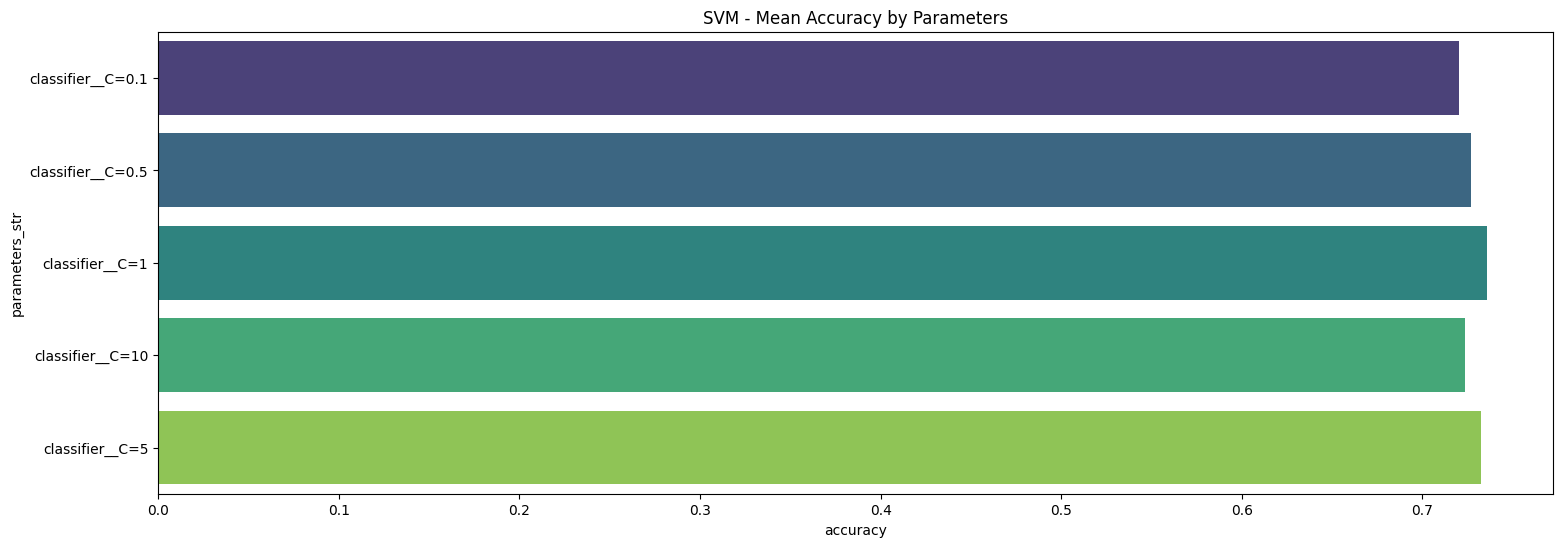

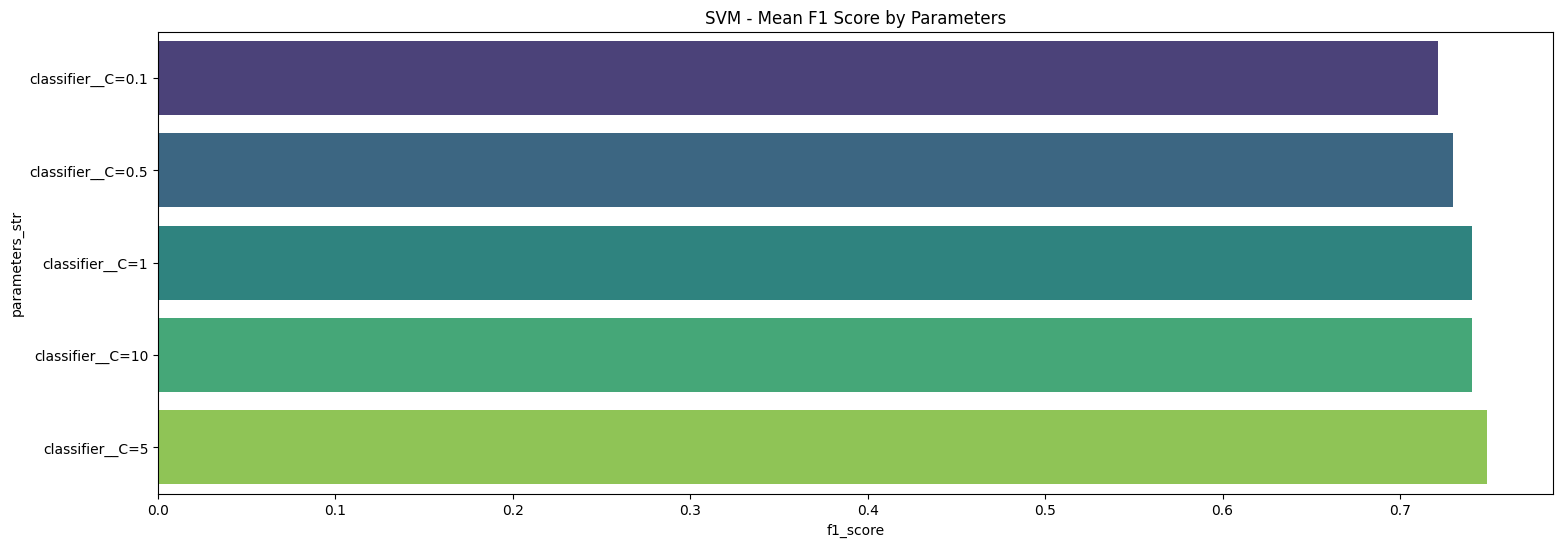

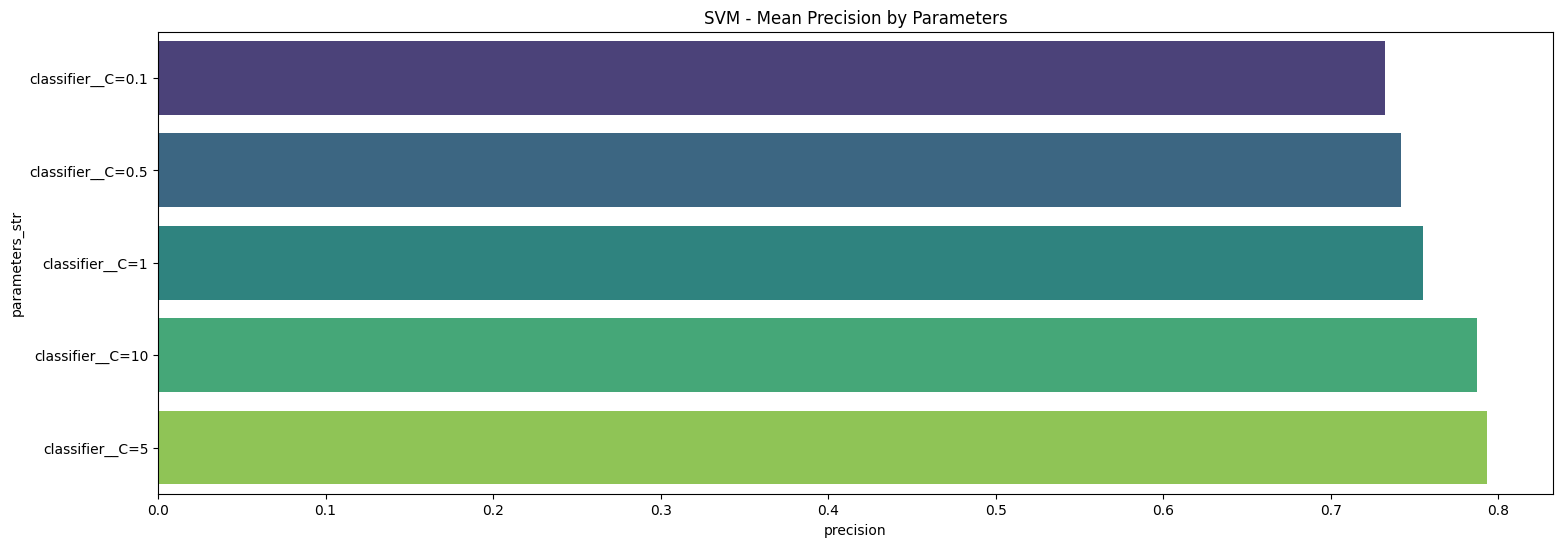

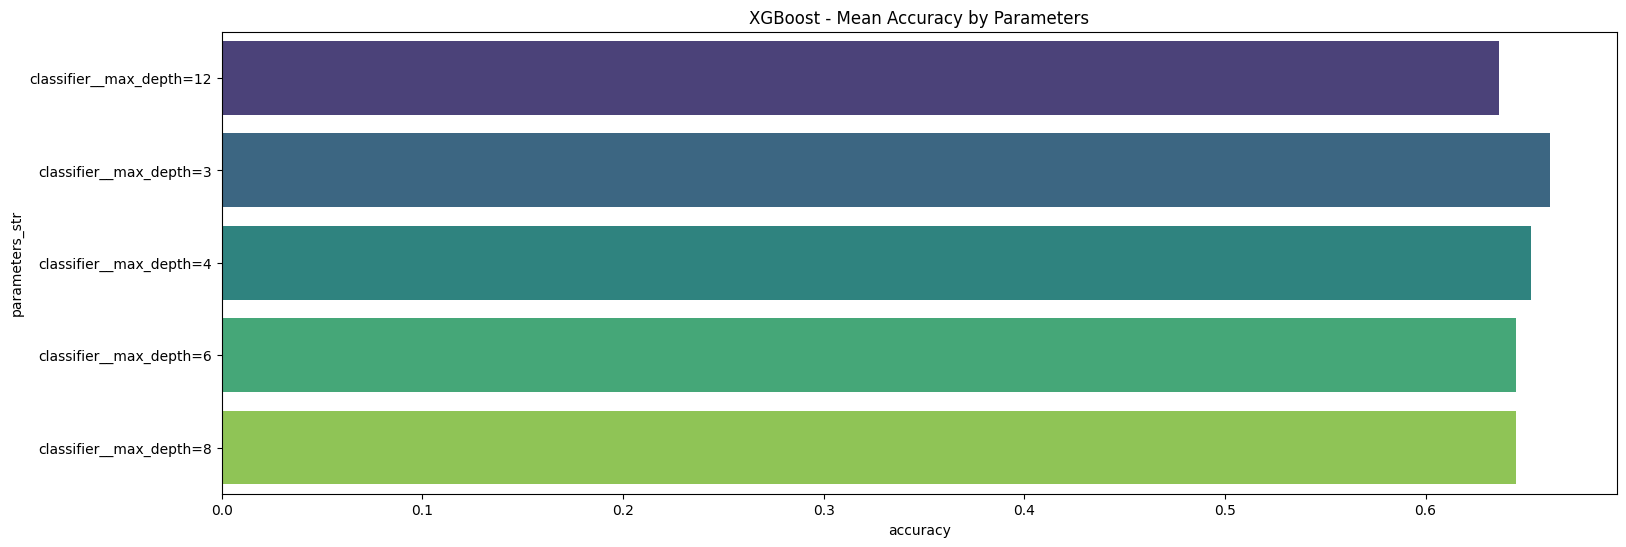

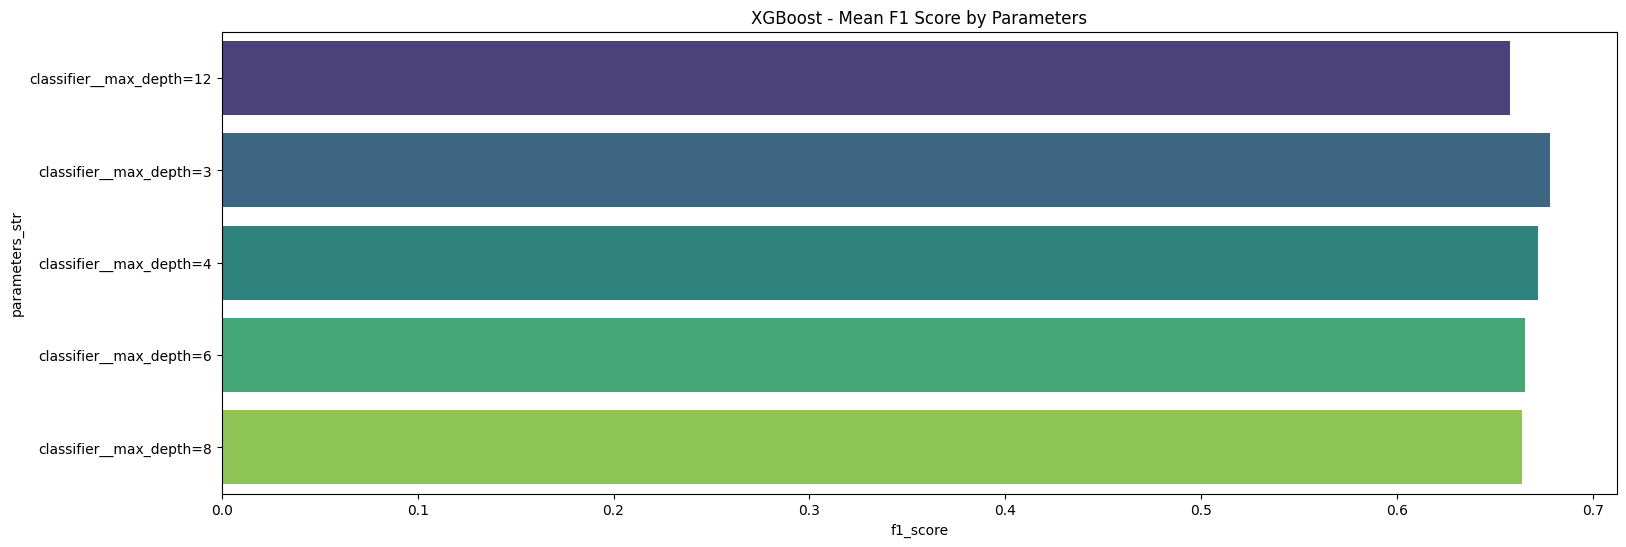

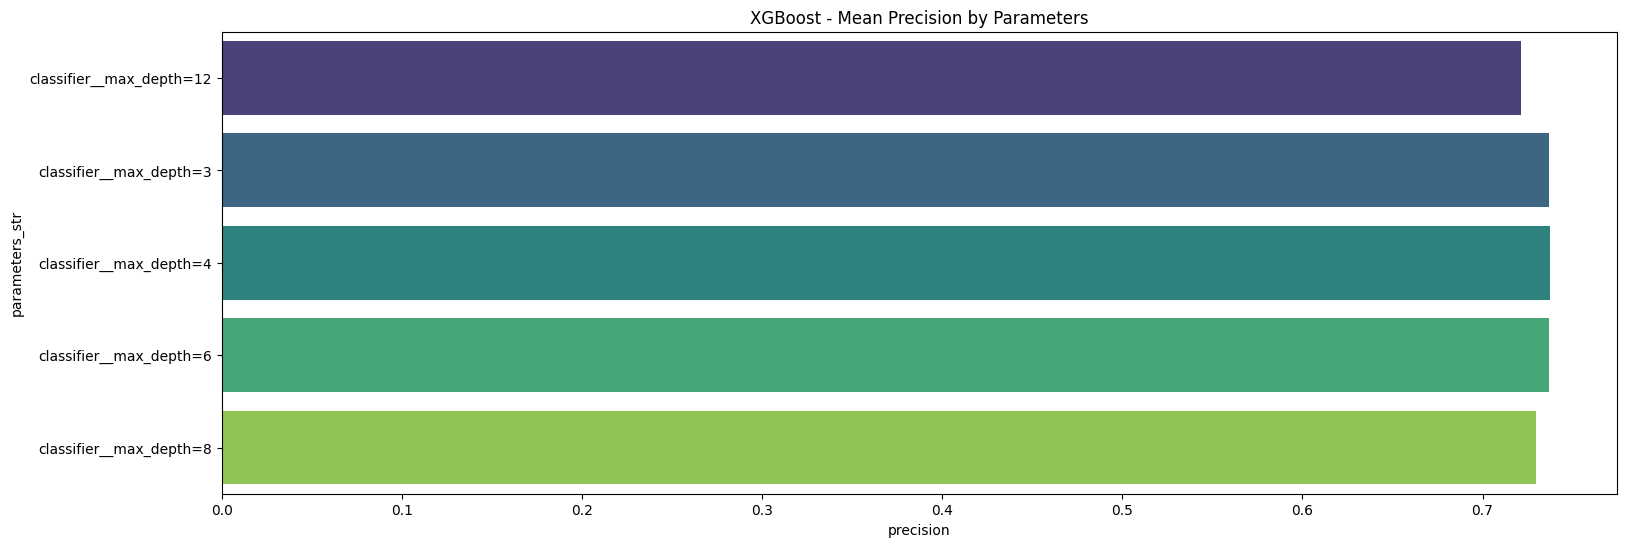

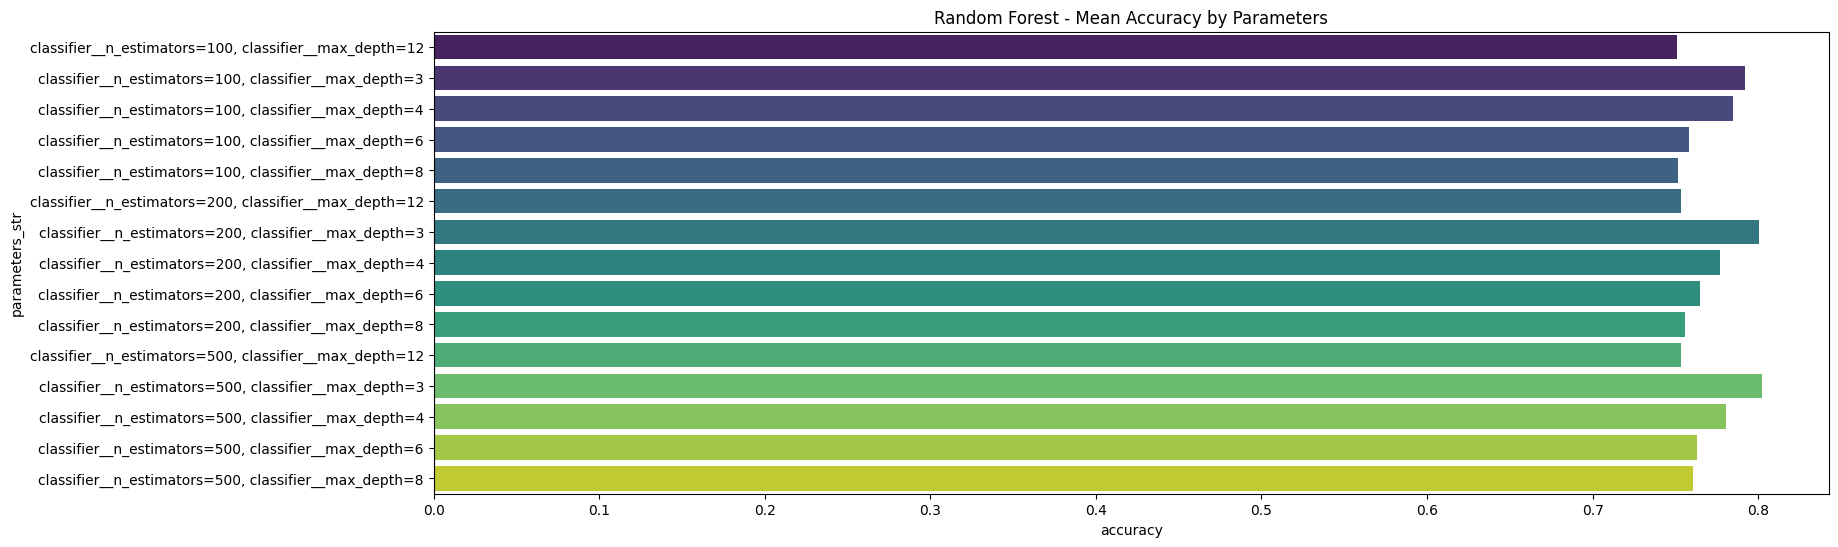

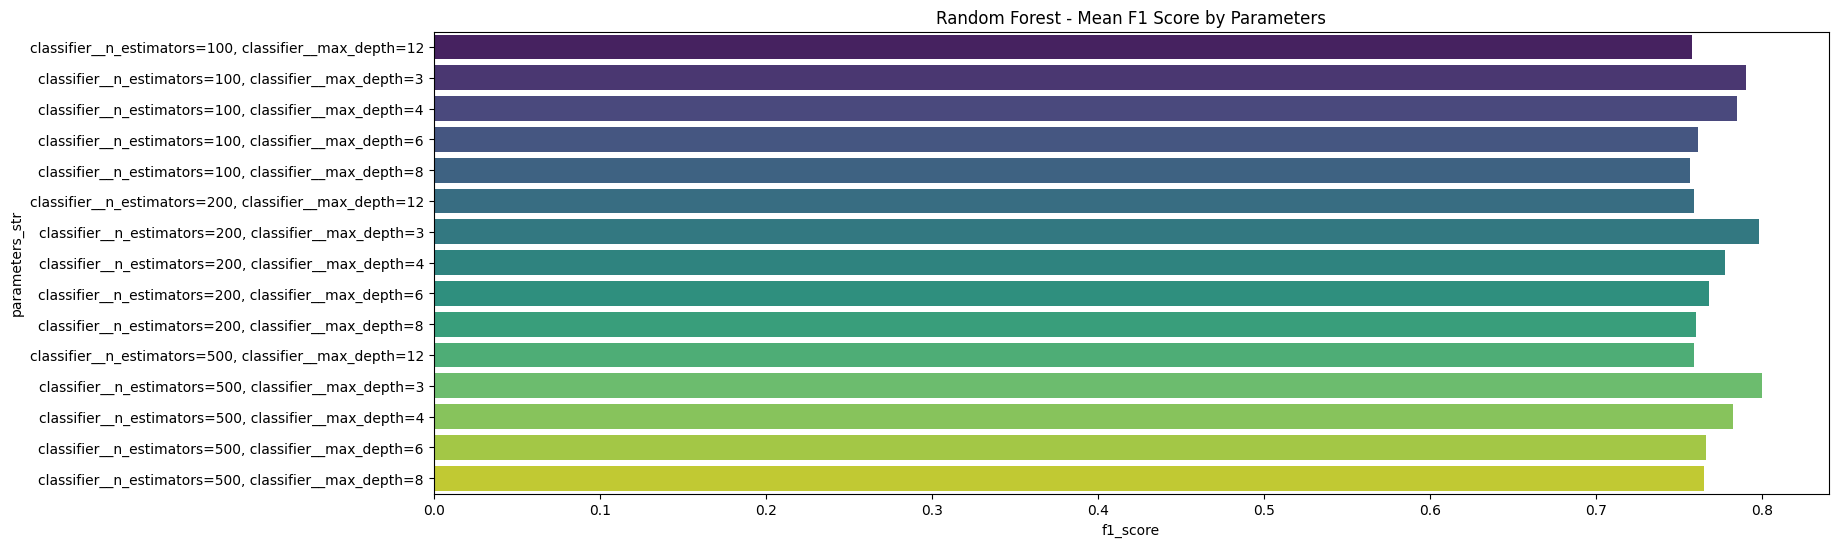

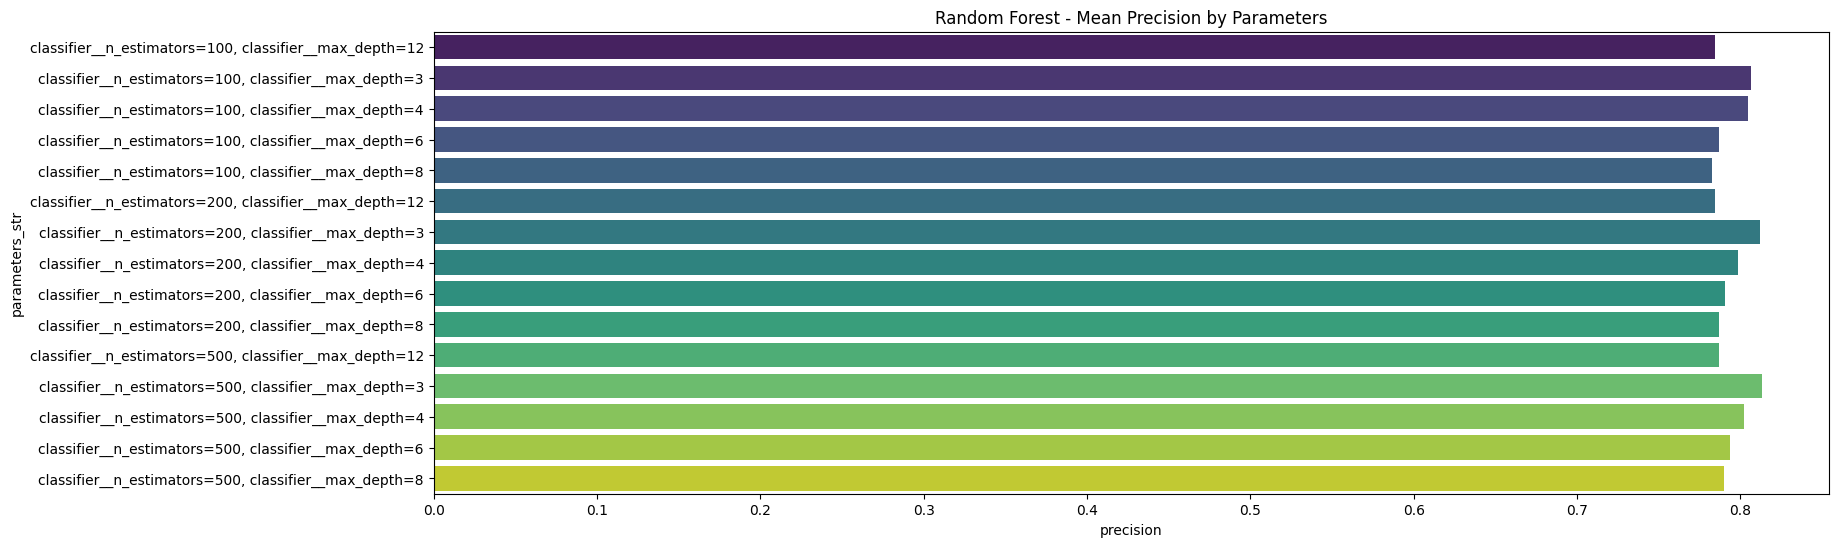

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_for_model(df, model_name):
    # Convert 'parameters' to a concise string format
    df['parameters_str'] = df['parameters'].apply(lambda x: ', '.join(f"{k}={v}" for k, v in x.items()))
    
    # Calculate mean metrics for each unique parameter
    mean_metrics = df.groupby('parameters_str').agg({
        'accuracy': 'mean',
        'f1_score': 'mean',
        'precision': 'mean'
    }).reset_index()

    # Plot the results
    plt.figure(figsize=(18, 6))

    # Plot Accuracy
    sns.barplot(x='accuracy', y='parameters_str', data=mean_metrics, palette='viridis')
    plt.title(f'{model_name} - Mean Accuracy by Parameters')
    plt.show()
    plt.figure(figsize=(18, 6))

    # Plot F1 Score
    sns.barplot(x='f1_score', y='parameters_str', data=mean_metrics, palette='viridis')
    plt.title(f'{model_name} - Mean F1 Score by Parameters')
    plt.show()

    # Plot Precision
    plt.figure(figsize=(18, 6))

    sns.barplot(x='precision', y='parameters_str', data=mean_metrics, palette='viridis')
    plt.title(f'{model_name} - Mean Precision by Parameters')

    # plt.tight_layout()
    plt.show()

# Plot metrics for each model
for model_name, df in model_dfs.items():
    plot_metrics_for_model(df, model_name)

In [ ]:
# we choose the best model - random forest
# Best parameters: 
# 'classifier__n_estimators':  200,
# 'classifier__max_depth': 3


In [200]:
df = pd.read_csv(f"{parent_dir}/Data/features_4_model.csv")

# Data preparation
X = df.drop(columns=['label', 'person', 'question', 'gender_count_-1' ,'number_count_-1'])
y = df['label']
groups = df['person']
unique_persons = np.unique(groups)
train_persons, test_persons = train_test_split(unique_persons, test_size=0.25,random_state=2)
train_mask = groups.isin(train_persons)
test_mask = groups.isin(test_persons)
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Define the pipeline with the chosen Random Forest parameters and sampling
over_sampler = SMOTE(sampling_strategy='minority')

imbalanced_pipeline = ImbalancedPipeline([
    ('sampling', over_sampler),  # Oversampling step
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=3))  # Model step
])

# Train the model
imbalanced_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = imbalanced_pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Random Forest - Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(report)

# Add predictions to the test DataFrame and connect back to the original data
test_df = df[test_mask].copy()
test_df['prediction'] = y_pred


Random Forest - Accuracy: 0.9250
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95       306
           1       0.67      1.00      0.80        54

    accuracy                           0.93       360
   macro avg       0.83      0.96      0.88       360
weighted avg       0.95      0.93      0.93       360



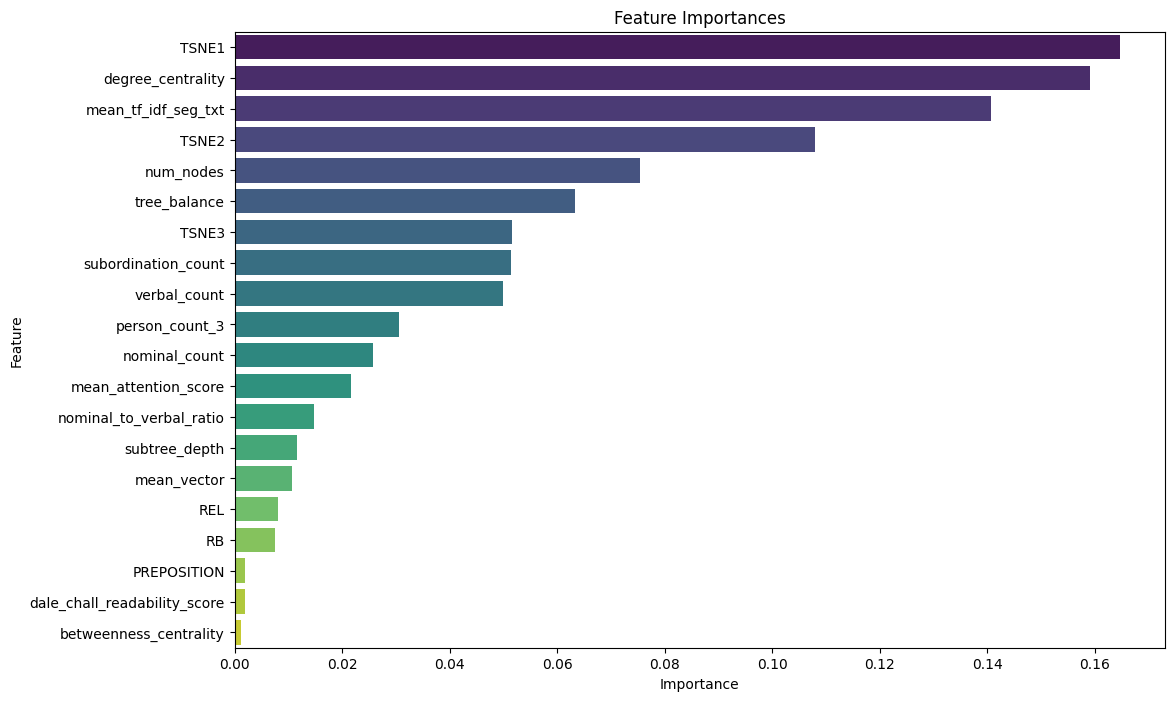

In [201]:
# Extract feature importances
classifier = imbalanced_pipeline.named_steps['classifier']
importances = classifier.feature_importances_
features = X.columns

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [202]:
df_test_ = test_df[['question' ,'label' ,'person' ,'prediction'	]]
df_test_.head()

,question,label,person,prediction
18,בר מצווה,1,אש2.docx,1
19,מה אוהב לעשות,1,אש2.docx,1
20,מה מעצבן,1,אש2.docx,1
21,משאלות לעתיד,1,אש2.docx,1
22,תמונה 1,1,אש2.docx,1


In [203]:
# Calculate TP, FP, TN, FN
TP = ((df_test_['label'] == 1) & (df_test_['prediction'] == 1)).sum()
FP = ((df_test_['label'] == 0) & (df_test_['prediction'] == 1)).sum()
TN = ((df_test_['label'] == 0) & (df_test_['prediction'] == 0)).sum()
FN = ((df_test_['label'] == 1) & (df_test_['prediction'] == 0)).sum()


# Total positives (P) and negatives (N)
P = (df_test_['label'] == 1).sum()
N = (df_test_['label'] == 0).sum()

# Calculate metrics
TPR = TP / P if P > 0 else 0
FNR = FN / P if P > 0 else 0
TNR = TN / N if N > 0 else 0
FPR = FP / N if N > 0 else 0

# Print results
print(f"True Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")

print(f"True Positive Rate (TPR) / Recall / Sensitivity (SEN): {TPR:.2%}")
print(f"False Negative Rate (FNR): {FNR:.2%}")
print(f"True Negative Rate (TNR) / Specificity (SPC): {TNR:.2%}")
print(f"False Positive Rate (FPR): {FPR:.2%}")

True Positives (TP): 54
False Negatives (FN): 0
True Negatives (TN): 279
False Positives (FP): 27
True Positive Rate (TPR) / Recall / Sensitivity (SEN): 100.00%
False Negative Rate (FNR): 0.00%
True Negative Rate (TNR) / Specificity (SPC): 91.18%
False Positive Rate (FPR): 8.82%


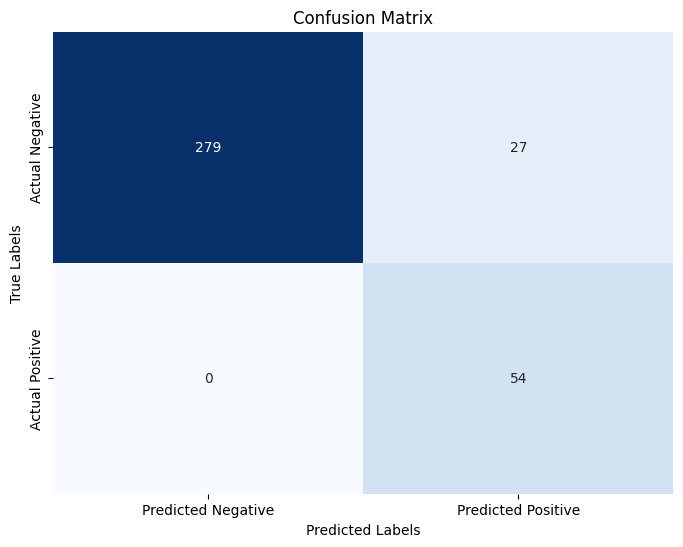

In [204]:
# Confusion Matrix
conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

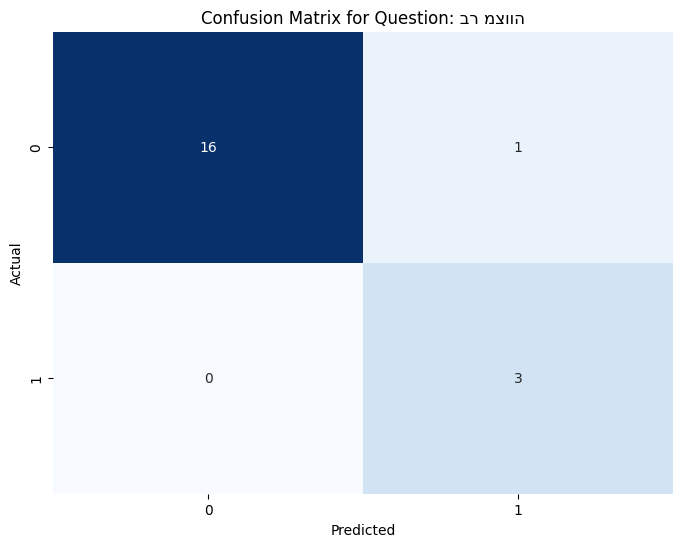

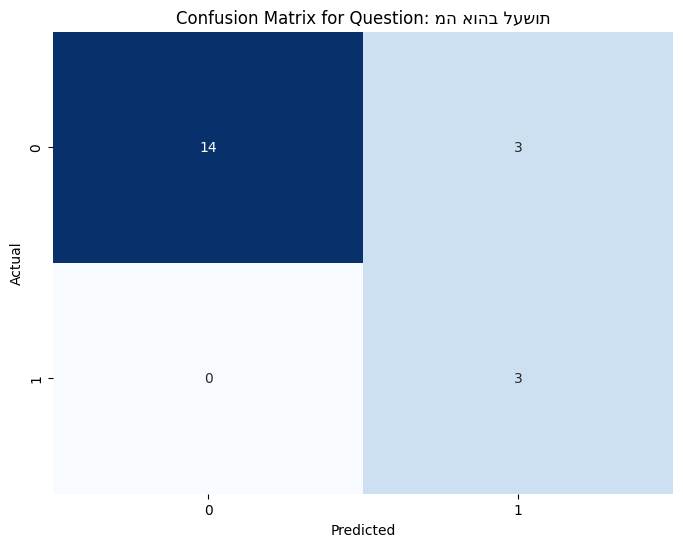

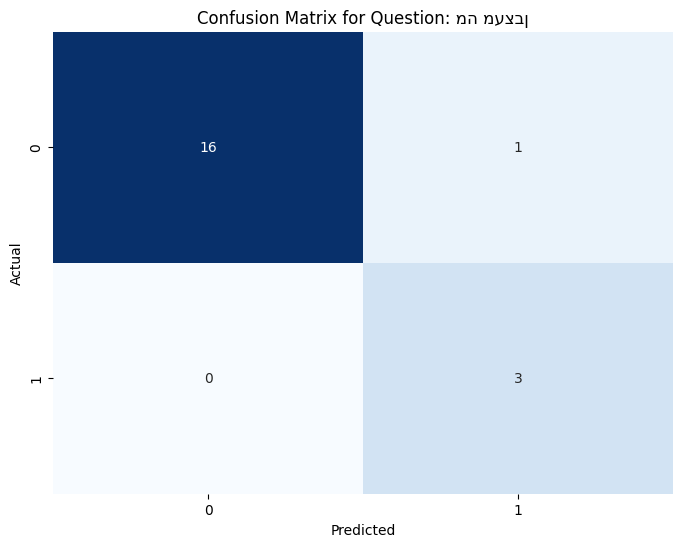

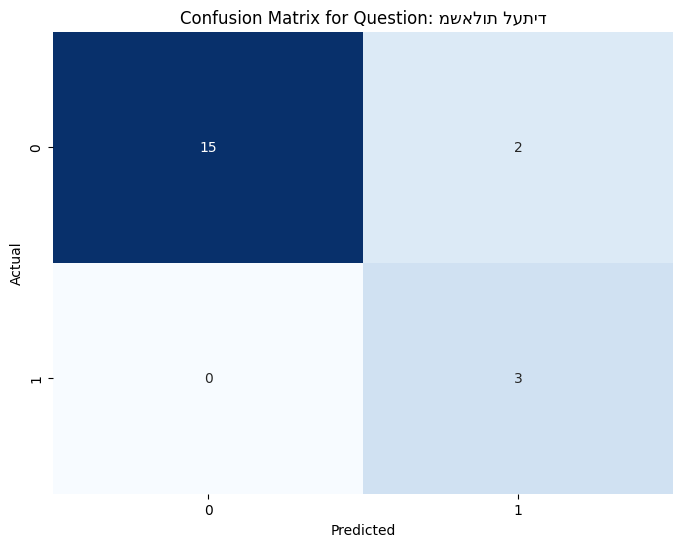

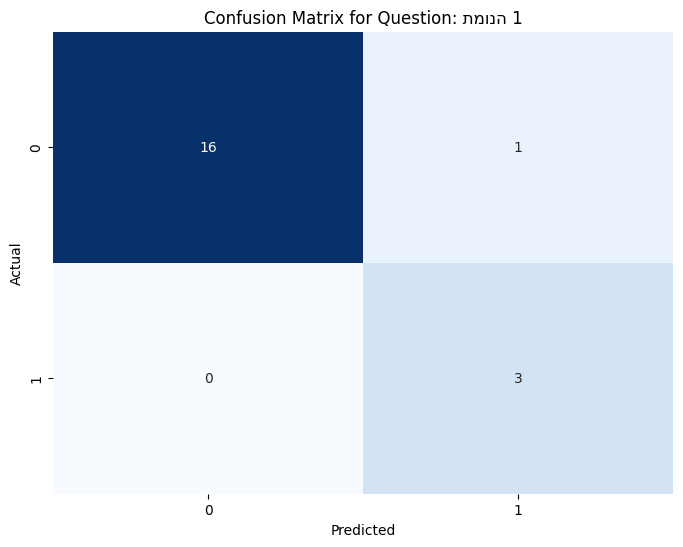

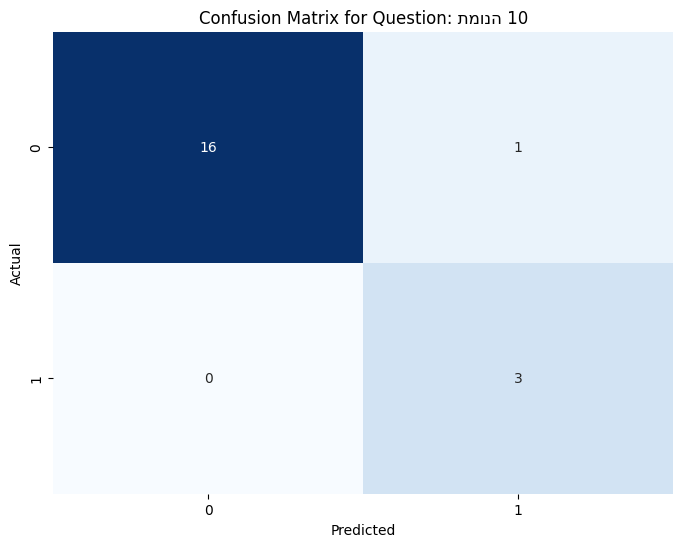

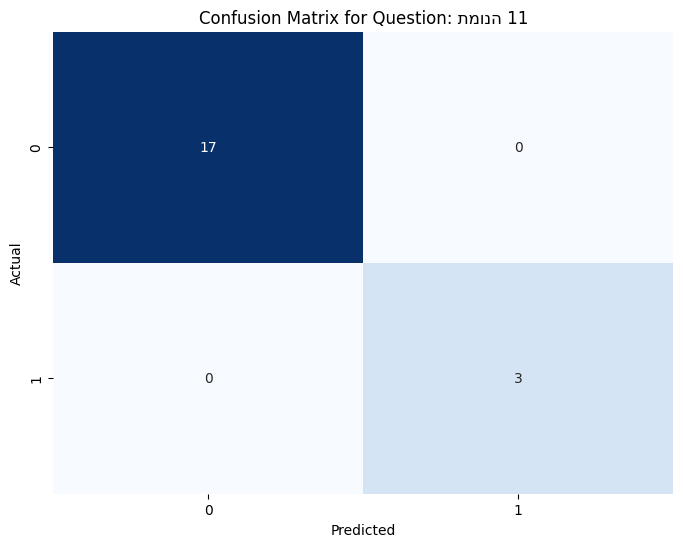

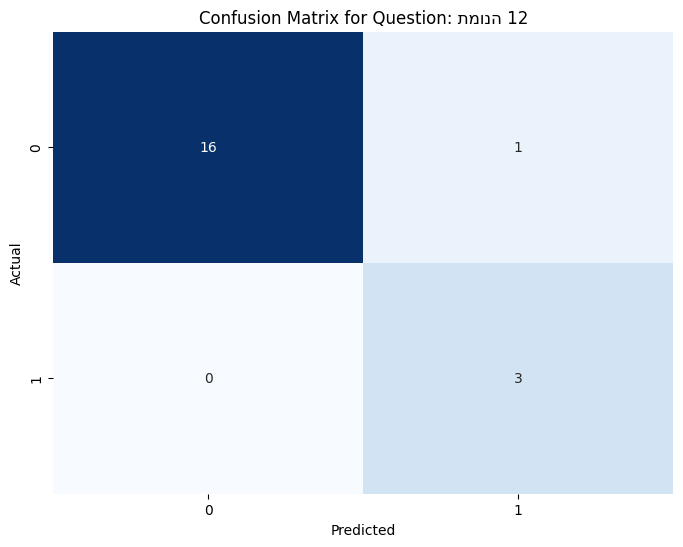

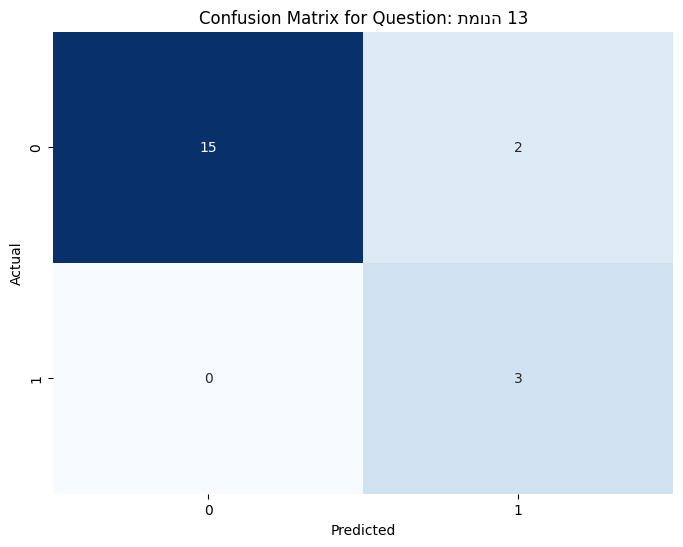

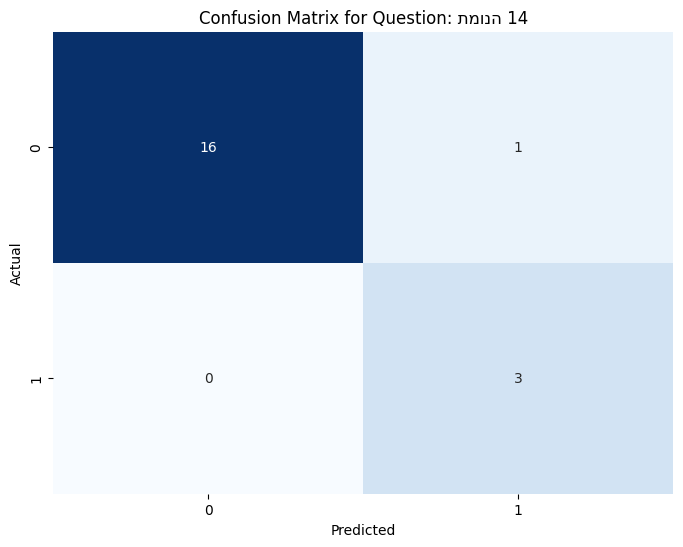

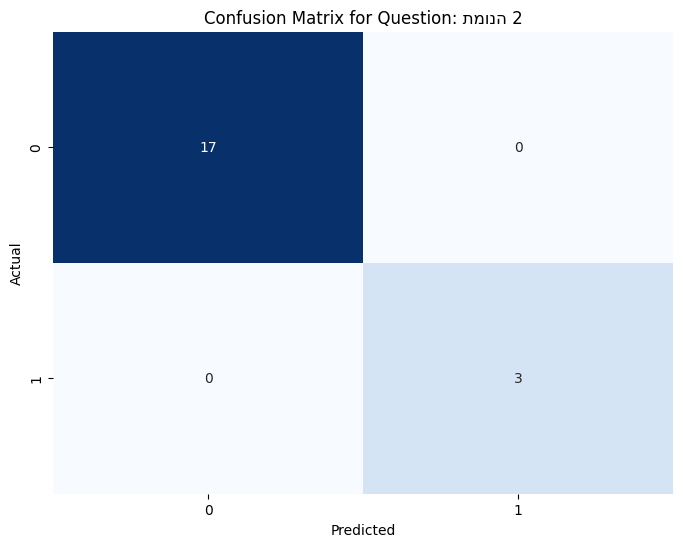

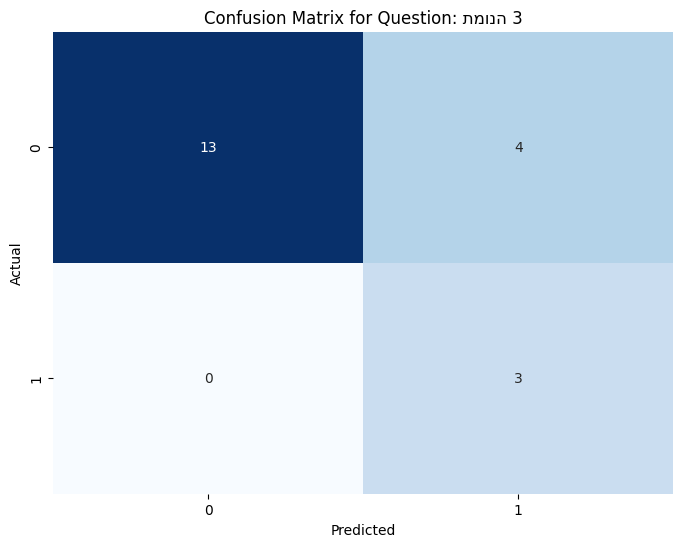

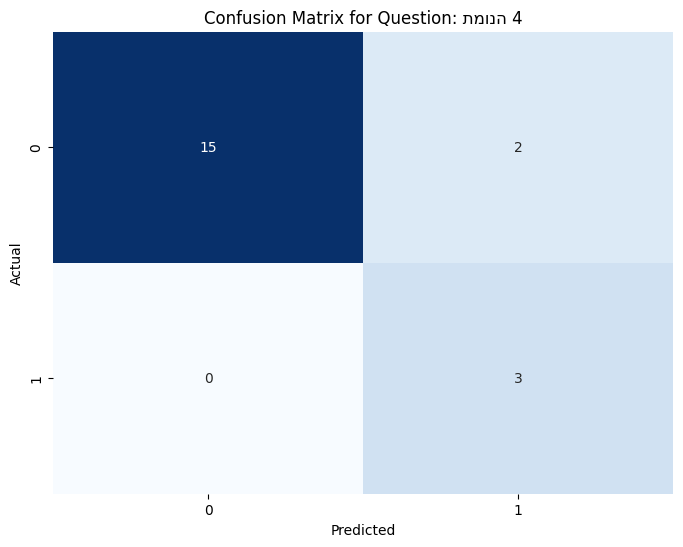

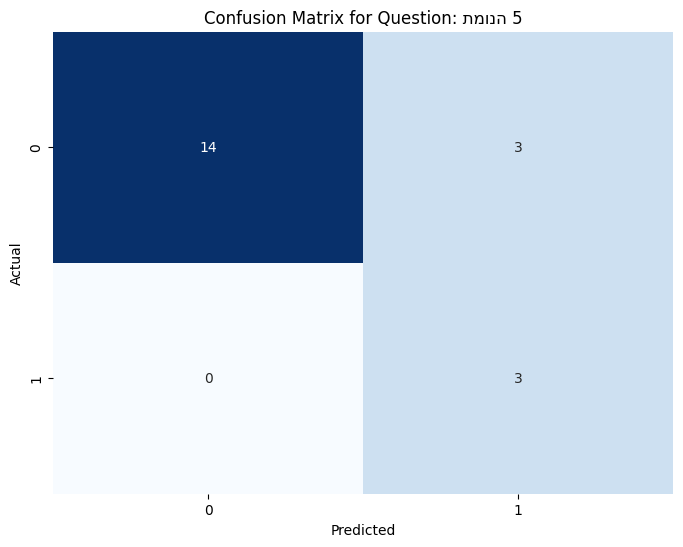

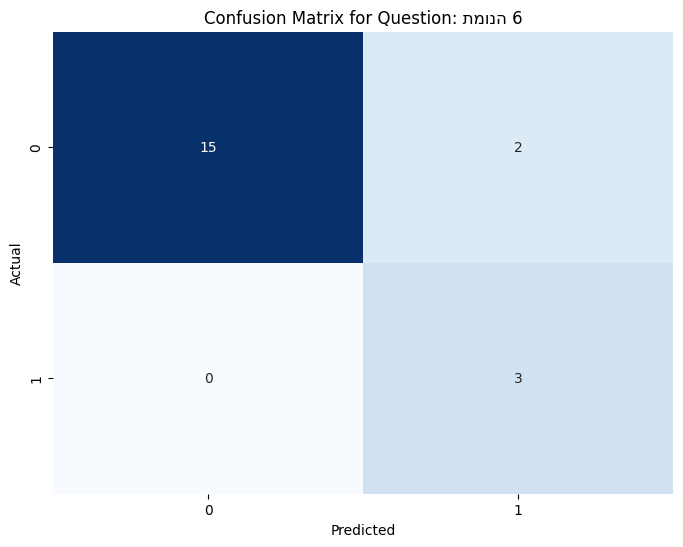

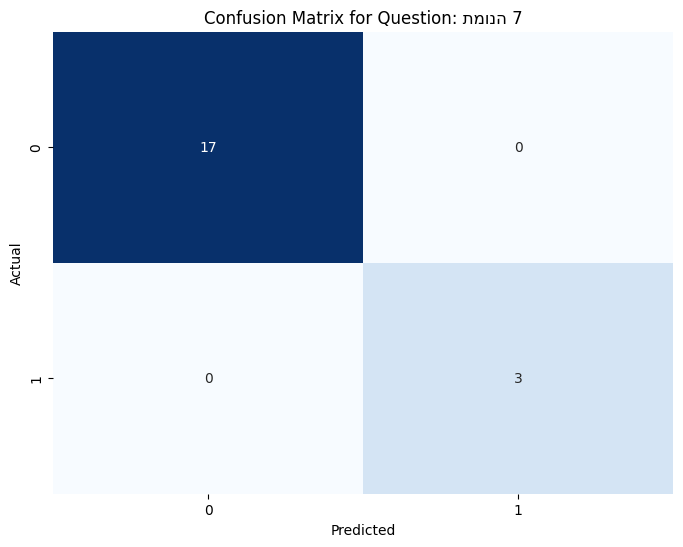

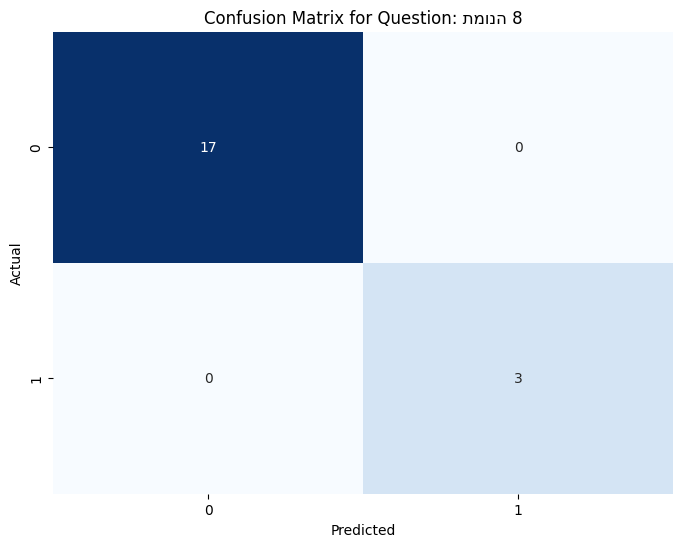

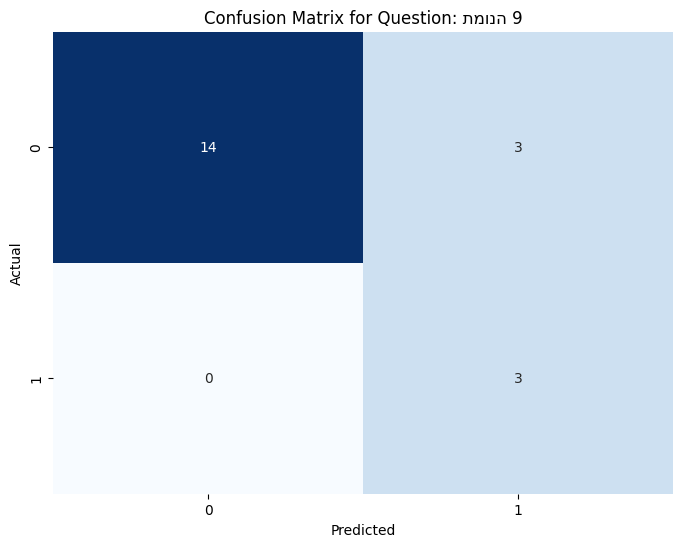

In [205]:
from sklearn.metrics import confusion_matrix

# Sample DataFrame with predictions and true labels
tmp_df = test_df[['question', 'label', 'prediction']]

# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Group by question and plot confusion matrix for each group
for question, group in tmp_df.groupby('question'):
    y_true = group['label']
    y_pred = group['prediction']
    plot_confusion_matrix(y_true, y_pred, f'Confusion Matrix for Question: {question}')


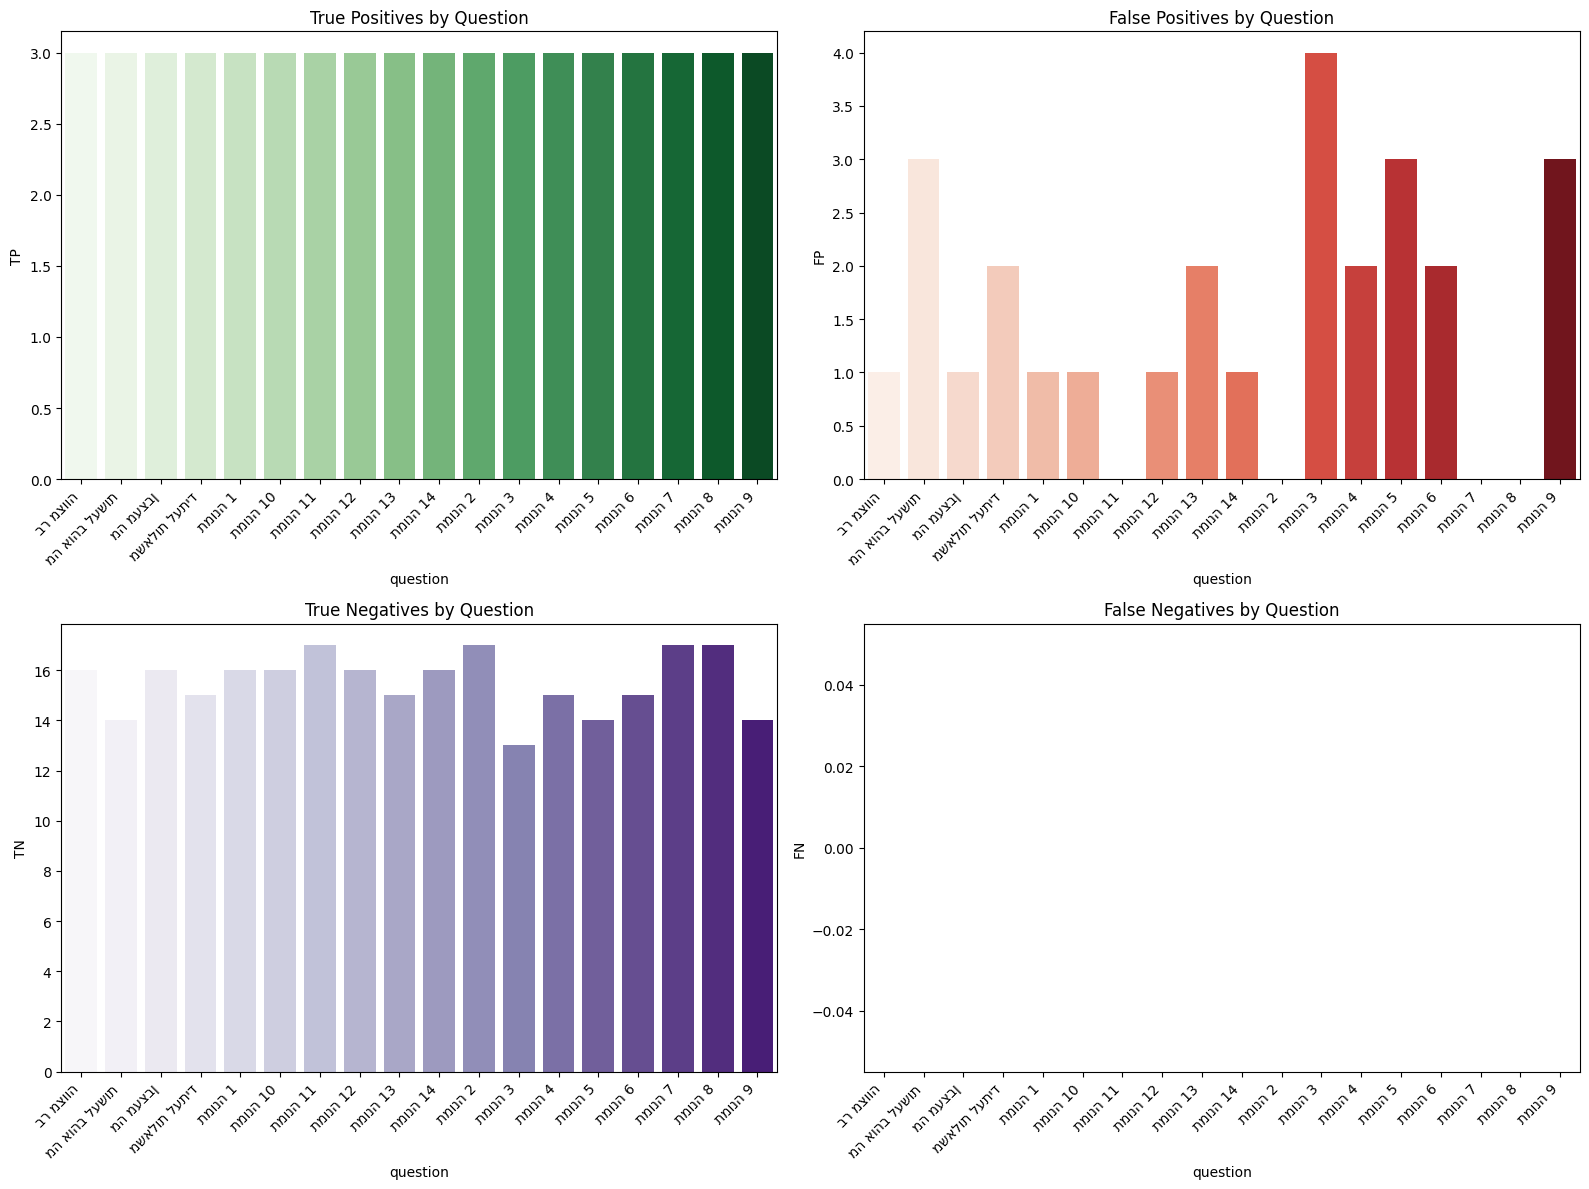

In [207]:


# Sample DataFrame with predictions and true labels
tmp_df = test_df[['question', 'label', 'person', 'prediction']]

# Calculate errors
tmp_df['TP'] = ((tmp_df['prediction'] == 1) & (tmp_df['label'] == 1)).astype(int)
tmp_df['FP'] = ((tmp_df['prediction'] == 1) & (tmp_df['label'] == 0)).astype(int)
tmp_df['TN'] = ((tmp_df['prediction'] == 0) & (tmp_df['label'] == 0)).astype(int)
tmp_df['FN'] = ((tmp_df['prediction'] == 0) & (tmp_df['label'] == 1)).astype(int)

# Aggregate errors by question
error_summary = tmp_df.groupby('question').agg({
    'TP': 'sum',
    'FP': 'sum',
    'TN': 'sum',
    'FN': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(16, 12))

# Plot True Positives
plt.subplot(2, 2, 1)
sns.barplot(x='question', y='TP', data=error_summary, palette='Greens')
plt.xticks(rotation=45, ha='right')
plt.title('True Positives by Question')

# Plot False Positives
plt.subplot(2, 2, 2)
sns.barplot(x='question', y='FP', data=error_summary, palette='Reds')
plt.xticks(rotation=45, ha='right')
plt.title('False Positives by Question')

# Plot True Negatives
plt.subplot(2, 2, 3)
sns.barplot(x='question', y='TN', data=error_summary, palette='Purples')
plt.xticks(rotation=45, ha='right')
plt.title('True Negatives by Question')

# Plot False Negatives
plt.subplot(2, 2, 4)
sns.barplot(x='question', y='FN', data=error_summary, palette='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('False Negatives by Question')

plt.tight_layout()
plt.show()


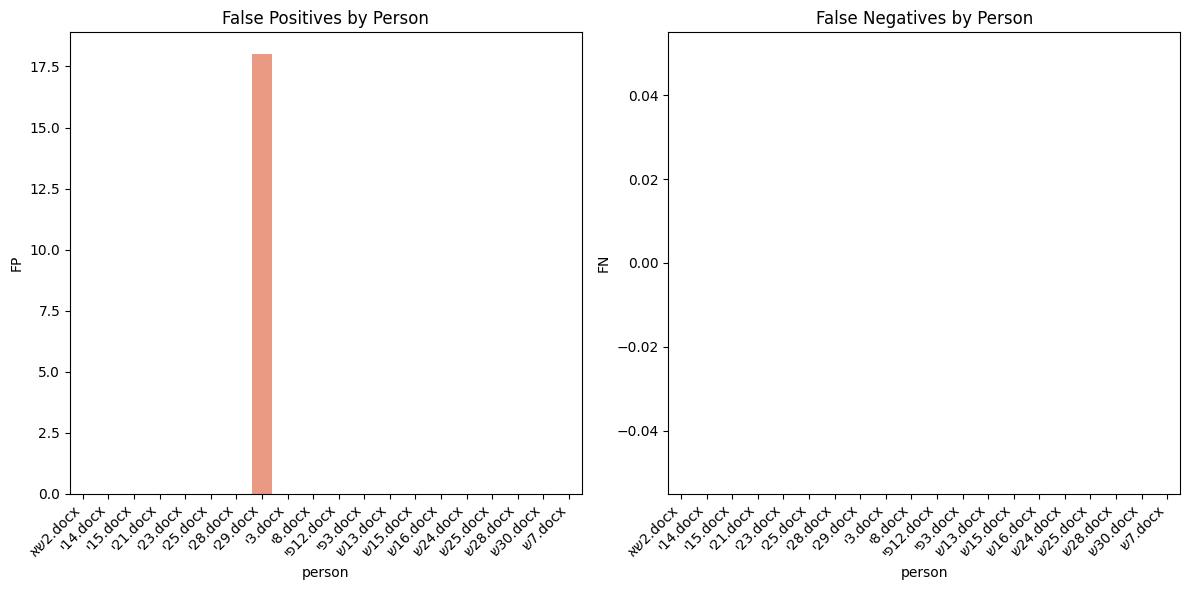

In [172]:
tmp_df = test_df[['question' ,'label' ,'person' ,'prediction'	]]

# Calculate average prediction for each person
avg_predictions = tmp_df.groupby('person')['prediction'].mean().reset_index()

# Convert average predictions to binary labels using majority voting
avg_predictions['majority_vote'] = (avg_predictions['prediction'] > 0.5).astype(int)

# Merge back with original dataframe to include the majority vote in the original data
tmp_df = tmp_df.merge(avg_predictions[['person', 'majority_vote']], on='person', how='left')

# Calculate errors based on majority vote
tmp_df['FP'] = ((tmp_df['majority_vote'] == 1) & (tmp_df['label'] == 0)).astype(int)
tmp_df['FN'] = ((tmp_df['majority_vote'] == 0) & (tmp_df['label'] == 1)).astype(int)

# Aggregate errors by person
error_summary = tmp_df.groupby('person').agg({
    'FP': 'sum',
    'FN': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot False Positives
plt.subplot(1, 2, 1)
sns.barplot(x='person', y='FP', data=error_summary, palette='Reds')
plt.xticks(rotation=45, ha='right')
plt.title('False Positives by Person')

# Plot False Negatives
plt.subplot(1, 2, 2)
sns.barplot(x='person', y='FN', data=error_summary, palette='Blues')
plt.xticks(rotation=45, ha='right')
plt.title('False Negatives by Person')

plt.tight_layout()
plt.show()